In [1]:
! kaggle datasets download -d jahidhasan66/isprs-potsdam

Dataset URL: https://www.kaggle.com/datasets/jahidhasan66/isprs-potsdam
License(s): unknown
 94% 346M/366M [00:02<00:00, 178MB/s]
100% 366M/366M [00:02<00:00, 156MB/s]


In [2]:
!unzip isprs-potsdam.zip -d ./isprs_potsdam

Archive:  isprs-potsdam.zip
  inflating: ./isprs_potsdam/patches/Images/Image_0.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_10.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_100.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1000.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1001.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1002.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1003.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1004.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1005.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1006.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1007.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1008.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1009.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_101.tif  
  inflating: ./isprs_potsdam/patches/Images/Image_1010.tif  
  infl

In [49]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, ignore_index=-1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)  # pt is the predicted probability for the actual class
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss

class PartialCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, ignore_index=-1):
        super(PartialCrossEntropyLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, ignore_index=ignore_index)

    def forward(self, inputs, targets):
        # Apply focal loss to all pixels
        focal_loss = self.focal_loss(inputs, targets)

        # Create a mask for the labeled pixels (where target != ignore_index)
        mask = (targets != self.focal_loss.ignore_index).float()

        # Apply the mask to the focal loss
        masked_loss = focal_loss * mask

        # Calculate the partial cross-entropy loss
        partial_loss = masked_loss.sum() / mask.sum()

        return partial_loss




def map_labels(mask):
    # Map labels [0, 29, 76, 150, 179, 226] to [0, 1, 2, 3, 4, 5]
    # Set background (255) to -1, which will be ignored in the loss function
    label_map = {0: 0, 29: 1, 76: 2, 150: 3, 179: 4, 226: 5, 255: -1}
    mapped_mask = torch.from_numpy(np.vectorize(label_map.get)(mask.numpy())).long()
    return mapped_mask


Using the Euclidean distance takes much time. The solution is to utilize The KDTree to efficiently find pairs of pixels within a certain distance D, significantly reducing the number of pairwise distance calculations compared to a brute-force approach, reducing the complexity from
𝑂
(
𝑛
2
)
O(n
2
 ) to approximately
𝑂
(
𝑛
log
⁡
𝑛
)
O(nlogn).

In [50]:
import numpy as np
from PIL import Image
from skimage.draw import line

def link_pixels(image: Image, D: int) -> Image:
    # Convert the PIL image to a NumPy array and ensure it's of type uint8
    img_array = np.array(image, dtype=np.uint8)

    # Get the unique grayscale values in the image (excluding the background)
    unique_values = np.unique(img_array)
    unique_values = unique_values[unique_values != 255]  # Remove the background value

    # Create a copy of the image array to modify
    linked_array = img_array.copy()

    # Precompute D^2 to avoid repeated square root calculations
    D_squared = D * D

    # Process each grayscale value (each class)
    for value in unique_values:
        # Find the coordinates of all pixels belonging to the current class
        coords = np.argwhere(img_array == value)

        # Use a KDTree for efficient neighbor searching
        from scipy.spatial import KDTree
        tree = KDTree(coords)
        pairs = tree.query_pairs(r=D, p=2)

        # Iterate over pairs of coordinates within distance D
        for i, j in pairs:
            coord1, coord2 = coords[i], coords[j]

            # Use Bresenham's algorithm (or equivalent) to find the line between the pixels
            rr, cc = line(coord1[0], coord1[1], coord2[0], coord2[1])

            # Set the pixels along the line to the current class value
            linked_array[rr, cc] = value

    # Convert the modified NumPy array back to a PIL image
    linked_image = Image.fromarray(linked_array)

    return linked_image


In [51]:
import torch
from torchvision import models,transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
import random

class ToTensorNoScaling:
    def __call__(self, img):
        return torch.from_numpy(np.array(img)).long()
# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    ToTensorNoScaling()
])

# Custom dataset class
class ISPRSPotsdamDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, target_transform=None, points_per_class=10):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.points_per_class = points_per_class  # Number of points to sample per class
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def sample_points(self, mask):
        """
        Randomly samples points from the fully labeled mask.
        """
        # print("this is the type inside the funct",type(mask))
        mask = np.array(mask)  # Convert to numpy array for processing

        unique_labels = np.unique(mask)
        sparse_mask = np.full_like(mask,255)


        for label in unique_labels:
            if label == 255:  # Assuming 255 is the background, skip it
                continue

            # Get indices of all pixels belonging to this label
            y, x = np.where(mask == label)
            if len(x) > 0:  # Ensure there are points to sample
                indices = np.random.choice(len(x), min(self.points_per_class, len(x)), replace=False)
                # Set the chosen pixels to the label in the sparse mask
                sparse_mask[y[indices], x[indices]] = label



        """
        ****************************************************
        uncomment to see the masks when calling this function
        ****************************************************
        """
        # display("Original mask", mask)
        # display("Point-based mask",sparse_mask)


        return  Image.fromarray(sparse_mask,'L')  # Convert back to PIL Image

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_name = self.images[idx].replace('Image', 'Label')  # Adjust naming convention
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Sample sparse points from the mask
        sparse_mask = self.sample_points(mask) #simulation
        sparse_mask = link_pixels(sparse_mask,20) #link every two pixels that are less than 20 pixels apart


        """
        ****************************************************
        uncomment to see the New Mask when calling this function
        ****************************************************
        """
        # display("fill the spaces 1 time", sparse_mask )



        if self.image_transform:
            image = self.image_transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
            sparse_mask = self.target_transform(sparse_mask)



        return image,mask, sparse_mask






In [52]:
# Load dataset with the specified transformations
dataset = ISPRSPotsdamDataset(
    image_dir='./isprs_potsdam/patches/Images',
    mask_dir='./isprs_potsdam/patches/Labels',
    image_transform=image_transform,
    target_transform=target_transform,
    points_per_class=500
)


'Original mask'

array([[150, 150, 150, ..., 255, 255, 255],
       [150, 150, 150, ..., 255, 255, 255],
       [150, 150, 150, ..., 255, 255, 255],
       ...,
       [ 29,  29,  29, ...,  29,  29,  29],
       [ 29,  29,  29, ...,  29,  29,  29],
       [ 29,  29,  29, ...,  29,  29,  29]], dtype=uint8)
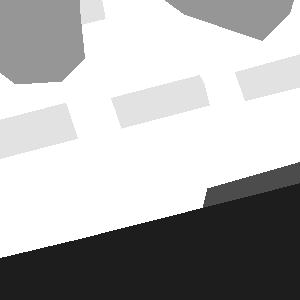

'Point-based mask'

array([[255, 150, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
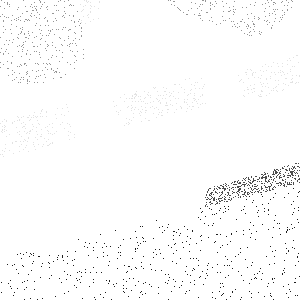

'fill the spaces 1 time'

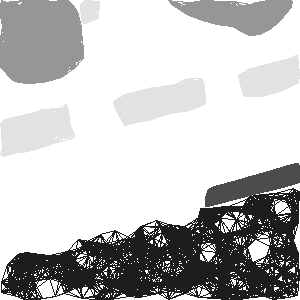

tensor([[[0.3216, 0.3098, 0.3059,  ..., 0.3176, 0.3137, 0.2980],
         [0.3216, 0.3137, 0.3059,  ..., 0.3216, 0.3098, 0.2980],
         [0.3176, 0.3137, 0.2941,  ..., 0.3059, 0.2980, 0.2863],
         ...,
         [0.4314, 0.3608, 0.2980,  ..., 0.2902, 0.2980, 0.3059],
         [0.4314, 0.3725, 0.2980,  ..., 0.3098, 0.3137, 0.3216],
         [0.4000, 0.3686, 0.2941,  ..., 0.3216, 0.3216, 0.3255]],

        [[0.2471, 0.2314, 0.2314,  ..., 0.3373, 0.3333, 0.3176],
         [0.2471, 0.2392, 0.2314,  ..., 0.3451, 0.3333, 0.3294],
         [0.2471, 0.2431, 0.2314,  ..., 0.3294, 0.3333, 0.3216],
         ...,
         [0.6353, 0.5451, 0.4745,  ..., 0.4078, 0.4196, 0.4353],
         [0.6392, 0.5647, 0.4745,  ..., 0.4275, 0.4392, 0.4510],
         [0.6118, 0.5608, 0.4667,  ..., 0.4431, 0.4471, 0.4588]],

        [[0.2157, 0.2000, 0.2000,  ..., 0.2980, 0.3098, 0.3059],
         [0.2196, 0.2078, 0.2000,  ..., 0.3137, 0.3137, 0.3098],
         [0.2196, 0.2157, 0.2000,  ..., 0.3059, 0.3059, 0.

In [47]:
image, mask, sparse_mask = dataset[21]
display(image)
display(mask)
display(sparse_mask)

#uncomment the lines in the ISPRSPotsdamDataset class definition Cell If you want to visualize the point-label mask before modification


'fill the spaces 2 times'

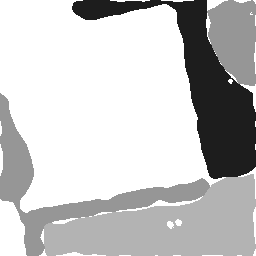

In [38]:

newmask=link_pixels(sparse_mask,5) # this is just for visualization
display("fill the spaces 2 times", newmask )

The second time took dramatically more time (about 13 seconds on a basic CPU, probably much less in a Google's TPU), but applying the function one single time on a mask with 500 labels took less than 1s to get good results

In [ ]:
# # Splitting the dataset into training, validation, and test sets
train_dataset, val_test_dataset = train_test_split(dataset, train_size=0.8, random_state=42)
val_dataset, test_dataset = train_test_split(val_test_dataset, train_size=0.5, random_state=42)

# Creating DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

This dataset contains 2400 labeled images, and the processings on each mask (simulate the sparse mask and adding the new link_pixel() function) takes around 1s per pixel, which explains the 40-45 minutes wait when loading the dataset.

In [ ]:
import torch.optim as optim
from torchvision import models
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

# Load the DeepLabV3 model with ResNet50 backbone
model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[4] = nn.Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))  # Adjust output layer to 6 classes

# Initialize the loss function and optimizer
criterion = PartialCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def iou_metric(outputs, labels):
    smooth = 1e-6

    # Get the predicted class for each pixel
    outputs = torch.argmax(outputs, dim=1)

    # Convert outputs to a binary mask
    outputs = (outputs > 0).float()

    # Convert labels to a binary mask (assuming binary class 1 is the target class)
    labels = (labels > 0).float()

    # Calculate intersection and union
    intersection = (outputs * labels).sum(dim=(1, 2))
    union = (outputs + labels).sum(dim=(1, 2)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        for images,masks, sparse_mask in train_loader:
            optimizer.zero_grad()


            # Map the sparse_mask to the new class indices
            sparse_mask = map_labels(sparse_mask)

            # Forward pass
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, sparse_mask)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calculate IoU metric
            iou = iou_metric(outputs, sparse_mask)
            running_iou += iou.item() * images.size(0)

        # Calculate average loss and IoU for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}')

        # Validation phase
        val_loss, val_iou = validate_model(model, val_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Save the model with the lowest validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    print('Training complete.')

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks, sparse_mask in val_loader:

            # Forward pass
            outputs = model(images)['out']

            sparse_mask = map_labels(sparse_mask)

            # Calculate loss using sparse sparse_mask
            loss = criterion(outputs, sparse_mask)
            val_loss += loss.item() * images.size(0)

            # Calculate IoU metric
            iou = iou_metric(outputs, sparse_mask)
            val_iou += iou.item() * images.size(0)

    return val_loss / len(val_loader.dataset), val_iou / len(val_loader.dataset)

# Testing function
def test_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    test_loss = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for images,masks,  sparse_mask in test_loader:

            # Forward pass
            outputs = model(images)['out']

            sparse_mask = map_labels(sparse_mask)

            # Calculate loss using sparse sparse_mask
            loss = criterion(outputs, sparse_mask)
            test_loss += loss.item() * images.size(0)

            # Calculate IoU metric
            iou = iou_metric(outputs, sparse_mask)
            test_iou += iou.item() * images.size(0)

    test_loss /= len(test_loader.dataset)
    test_iou /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

# Test the model
test_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 195MB/s]


Epoch 1/10, Training Loss: 0.5909, IoU: 0.0605
Epoch 1/10, Validation Loss: 0.2889, Validation IoU: 0.0612
Epoch 2/10, Training Loss: 0.2077, IoU: 0.0912
Epoch 2/10, Validation Loss: 0.2289, Validation IoU: 0.0614
Epoch 3/10, Training Loss: 0.1287, IoU: 0.1702
Epoch 3/10, Validation Loss: 0.2201, Validation IoU: 0.1213
Epoch 4/10, Training Loss: 0.0874, IoU: 0.1603
Epoch 4/10, Validation Loss: 0.1701, Validation IoU: 0.1445
Epoch 5/10, Training Loss: 0.0710, IoU: 0.2493
Epoch 5/10, Validation Loss: 0.1759, Validation IoU: 0.2015
Epoch 6/10, Training Loss: 0.0577, IoU: 0.4117
Epoch 6/10, Validation Loss: 0.1064, Validation IoU: 0.3192
Epoch 7/10, Training Loss: 0.0494, IoU: 0.5661
Epoch 7/10, Validation Loss: 0.0506, Validation IoU: 0.4616
Epoch 8/10, Training Loss: 0.0449, IoU: 0.7005
Epoch 8/10, Validation Loss: 0.0598, Validation IoU: 0.5874
Epoch 9/10, Training Loss: 0.0348, IoU: 0.8343
Epoch 9/10, Validation Loss: 0.0626, Validation IoU: 0.7027
Epoch 10/10, Training Loss: 0.0269, I